In [2]:
from __future__ import division
from __future__ import print_function

from IPython.display import display
from PIL import Image
import numpy as np
import random
from time import sleep
from tqdm import tqdm
from gym import wrappers


# Smart Cab
----
In this, we will use reinforcement learning to train a self-driving cab which will
pick up and drop passengers at designated areas. We will use Q-learning algorithm.

# Environment: Taxi-v2
----
We will use the Taxi-v2 environment by OpenAI Gym which looks something like this:

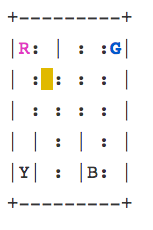

In [3]:

path="taxi.png"
display(Image.open(path))

The solid rectangle represents the taxi, which is yellow without a passenger and green with a passenger.
The pipe ("|") represents a wall which cannot be crossed.
R, G, Y, B are the possible pickup and destination locations. 
The blue letter represents the current passenger pick-up location. 
The purple letter is the current destination.


# How many states? Actions?

In [4]:
import gym

env = gym.make("Taxi-v3").env
Nstates = env.observation_space.n
Nactions = env.action_space.n
print("The number of states in taxi environment is", Nstates)
print("The number of actions in taxi environment is", Nactions)

The number of states in taxi environment is 500
The number of actions in taxi environment is 6


There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 

There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger

The actions are encoded as: 0 = south, 1 = north, 2 = east, 3 = west, 4 = pickup, 5 = dropoff.
The state is a tuple of taxi row position, taxi column position, passenger location and destination location. 

state = env.encode(3, 1, 2, 0) 
#(taxi row, taxi column, passenger pickup index, drop-off index)

if we have successfully picked up and dropped off a passenger, is called one episode

There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

In [5]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



# Training

A Q-value for a particular state-action combination is representative of the “quality” of an action taken from that state. Better Q-values imply better chances of getting greater rewards. here we are learning the proper action to take in the current state by looking at the reward for the current state/action combo, and the max rewards for the next state. This will eventually cause our taxi to consider the route with the best rewards strung together.

Steps Taken :
Initialize the Q-table by all zeros.

For each state, select any one among all possible actions for the current state (S).

Travel to the next state (S’) as a result of that action (a).

For all possible actions from the state (S’) select the one with the highest Q-value.

Update Q-table values using the equation.

Set the next state as the current state.

If the goal state is reached, then end and repeat the process.

In [6]:
#initialize the Q-table to a 500×6 matrix of zeros:
q = np.zeros([Nstates, Nactions])
# Hyperparameters
alpha = 0.1
gamma = 0.99
epsilon = 0.1


Nepisodes = 100000
for i in tqdm(range(Nepisodes)):
    
    state = env.reset()
    done = False
    epochs, penalties, reward, = 0, 0, 0
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Exploration
        else:
            action = np.argmax(q[state]) # Exploitation

        next_state, reward, done, info = env.step(action) 
        
        #Q-function
        old_value = q[state, action]
        next_max = np.max(q[next_state])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q[state, action] = new_value
        if reward==-10:
            penalties += 1

        state = next_state
        epochs += 1
print("****************************************\n")
print("Training finished.\n")

100%|██████████| 100000/100000 [00:34<00:00, 2876.09it/s]

****************************************

Training finished.



# Evaluation
After our Q-values have converged, lets use that to see how good it is. But before that, lets just fix the taxi position, pick up and destination.

In [8]:
testenv = gym.make('Taxi-v3')
testenv = testenv.unwrapped
state = testenv.encode(2, 2, 2, 1) # initializing (row, column, pickup, dropoff)
testenv.s = state
testenv.render()
penalties = 0
done = False
total_reward = 0
total_steps = 0 
while not done:
    
   
   #select action with maximum Q-value
    a =np.argmax(q[state])
    ########################## End of your code ########################
    next_s, reward, done, _ = testenv.step(a) # "a" is the action
    
    total_reward += reward
    total_steps += 1
    if reward == -10: # if hitting the wall
        penalties += 1
    
    testenv.render()
    state = next_s
    
    
print("Passenger dropped off successfully in after time steps ", total_steps)
print("Total reward is ", total_reward)
print("Penalties incurred", penalties)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
